# Import all the packages.

In [1]:
import DifferentialEquations
import DynamicalSystems
import Statistics
import Plots

In [2]:
using DynamicalSystems
using DifferentialEquations
using Statistics
using Plots

# The function of two coupled SQUIDs driven by a sinusoidal field.

$$\begin{align}
    \ddot{\phi_{1}} + g \dot{\phi_{1}} + v \sin (2 \pi \phi_{1})  + \frac{1}{1-e^{2}} \phi_{1} - \frac{e}{1-e^{2}} \phi_{2} = \frac{1}{1+e} \phi_{ext}\\
    \ddot{\phi_{2}} + g \dot{\phi_{2}} + v \sin (2 \pi \phi_{2})  + \frac{1}{1-e^{2}} \phi_{2} - \frac{e}{1-e^{2}} \phi_{1} = \frac{1}{1+e} \phi_{ext}
\end{align}$$

with:

$$ \phi_{ext} = fdc + fac  \cos (\Omega t) $$

In [74]:
@inline @inbounds function squid(u, p, t)
   g, v, fac, fdc, e, om = p # Here om = $ \Omega $
   x1, x2, y1, y2, z = u
   du1 = y1
   du2 = y2
   du3 = -g*y1 -(x1/(1-e*e)) -v*sin(2*pi*x1) + ((1-e)/(1-e*e))*(fac*cos(z) + fdc) +((e*x2)/(1-e*e))
   du4 = -g*y2 -(x2/(1-e*e)) -v*sin(2*pi*x2) + ((1-e)/(1-e*e))*(fac*cos(z) + fdc) +((e*x1)/(1-e*e))
   du5 = om
   return SVector{5}(du1, du2, du3, du4, du5)
end

squid (generic function with 1 method)

# The relative jacobian. 

In [4]:
@inline @inbounds function loop_jac(u, p, t)
    g, v, fac, fdc, e, om = p
    x1 = u[1]; x2 = u[2]; y1 = u[3]; y2 = u[4]; z = u[5]
    J = @SMatrix [0  0  1  0  0;
    0  0  0  1  0;
    -(1/(1-e*e))-v*2*pi*cos(2*pi*x1)  e/(1-e*e)  -g  0  -fac*((1-e)/(1-e*e))*sin(z);
    e/(1-e*e)  -(1/(1-e*e))-v*2*pi*cos(2*pi*x2)  0  -g  -fac*((1-e)/(1-e*e))*sin(z);
    0  0  0  0  0]
    return J
end

loop_jac (generic function with 1 method)

# Parameters.

In [8]:
g, v, fac, fdc, e, om = 0.024, 0.1369, 0.02, 0.0, 0.312, 1.2
p = [g, v, fac, fdc, e, om]
u0 = [5.0, 1.0, 2.0, 0.5, 0.0] # Initial Conditions.
ds = ContinuousDynamicalSystem(squid, u0, p, loop_jac)

5-dimensional continuous dynamical system
 state:       [5.0, 1.0, 2.0, 0.5, 0.0]
 e.o.m.:      squid
 in-place?    false
 jacobian:    loop_jac
 parameters:  [0.024, 0.1369, 0.02, 0.0, 0.312, 1.2]

# The range of Omega

In [42]:
om_initial = 0.86
om_final = 0.92
period_final = 2*pi/om_initial 
period_initial = 2*pi/om_final

period_step = 0.002 # The step of bifurcation on period.

period_range = period_initial:period_step:period_final # The range of bifurcation on period.

6.829549246934333:0.002:7.305549246934333

In [43]:
n_points = 10 # The nr of points that we want to keep for each value of the stroboscopic variable. 
nr_period = 500 # The nr of periods that we run the system plus nr of periods for the transient state.
per_step = 0.01 # The proportion of period that we want as an output.

f1_max = zeros(length(period_range), n_points)
omega = zeros(length(period_range))
size(omega), size(f1_max)

((239,), (239, 10))

# A test program for the possibility of multistability, quasiperiodicity or chaos in our system.

In [44]:

 for (i, period) in enumerate(period_range)
   # Parameters.
   om = (2*pi)/period
   set_parameter!(ds,6,om)
   global u0, nr_period, n_points, per_step
   
   # Runing the system.
   data = trajectory(ds, nr_period*period, dt=period*per_step, u0, Ttr = nr_period*period)
   
   # In order to have the maxima in each period.
   z1 = zeros(nr_period-1)
   s1 =convert(Int64,round(1.0/per_step,digits=0))
   for i=1:nr_period-1
      z1[i] = maximum( data[ i*s1+1:(i+1)*s1,1] ) # If you want stoboscopic in Φ2 variable you have to put 2 instead of 1.
   end
  
   # Holding only n_points. 
   f1_max[i,:]=z1[nr_period-(n_points+1):nr_period-2] 
   omega[i]=om
   
   # We have to put some noise because the system is multistable.
   s = 1*rand(4) 
   u0 = [data[end,1]+s[1],data[end,2]+s[2],data[end,3]+s[3],data[end,4]+s[4],0]

   # println(i)  If you want to print the steps.
 end

# Plots

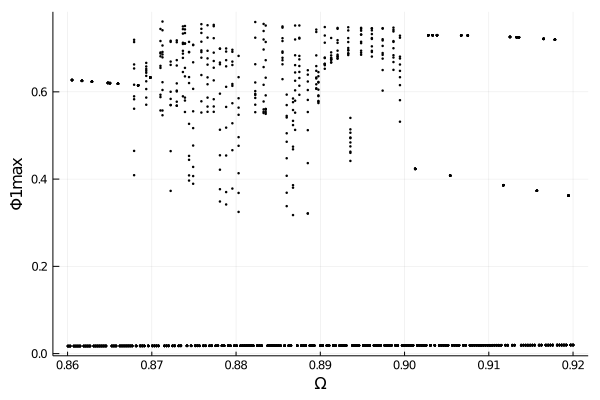

In [45]:
scatter(omega, f1_max, markersize=1.5, legend=:none, color = "black", xlabel="Ω", ylabel="Φ1max")
# savefig("Fig_01.png") if you want to save the fig.

# The main program.

In [46]:
nr_repetitions = 10 # The number of repetitions.
f1_max = zeros(length(period_range), nr_repetitions, n_points)
omega = zeros(length(period_range))
size(omega), size(f1_max)

((239,), (239, 10, 10))

In [49]:
for j=1:nr_repetitions 
   s2 = 4*rand(4) 
   u0 = [s2[1],s2[2],s2[3],s2[4], 0.0]
 for (i, period) in enumerate(period_range)
   # Parameters.
   om = (2*pi)/period
   set_parameter!(ds,6,om)
   global u0, nr_period, n_points, per_step
   
   # Runing the system.
   data = trajectory(ds, nr_period*period, dt=period*per_step, u0, Ttr = nr_period*period)
   
   # In order to have the maxima in each period.
   z1 = zeros(nr_period-1)
   s1 =convert(Int64,round(1.0/per_step,digits=0))
   for i=1:nr_period-1
      z1[i] = maximum( data[ i*s1+1:(i+1)*s1,1] ) 
   end
  
   # Holding only n_points. 
   f1_max[i,j,:]=z1[nr_period-(n_points+1):nr_period-2] 
   omega[i]=om
   
   # We have to put some noise because the system is multistable.
   s = 0.00001*rand(4) 
   u0 = [data[end,1]+s[1],data[end,2]+s[2],data[end,3]+s[3],data[end,4]+s[4],0]

   # println(i)  If you want to print the steps.
 end
    println(j) # if you want to print the nr of repetitions.
end    

1
2
3
4
5
6
7
8
9
10


# Main Plots

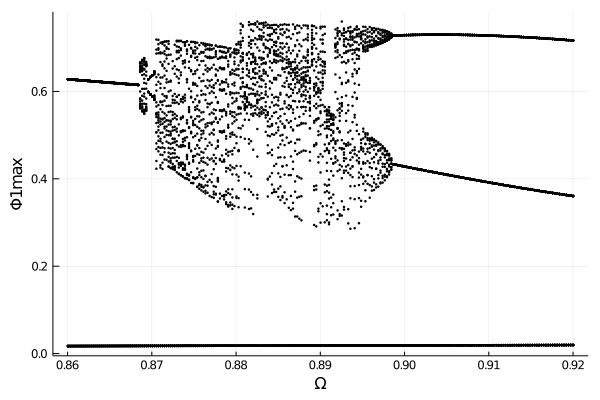

In [72]:
# If you want all the plots in one. Here nr_repetitions = 2. 
for j=1:2
  scatter!(omega, f1_max[:,j,:], markersize=1.5, legend=:none, color = "black", xlabel="Ω", ylabel="Φ1max")
end
current()

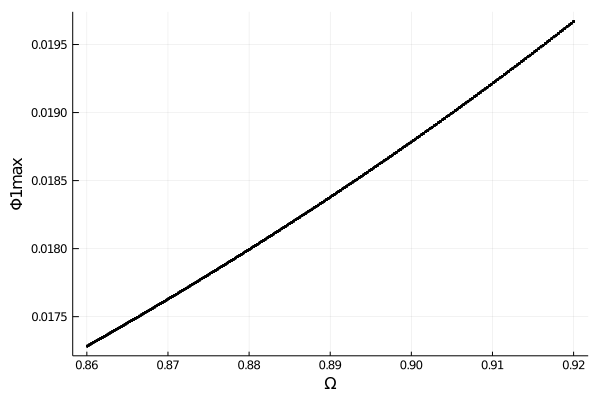

In [70]:
# If you want all the plots. 
for j=1:nr_repetitions
  IJulia.clear_output(true) # Deactivate it if you want each plot one after the other.
  plo = scatter(omega, f1_max[:,j,:], markersize=1.5, legend=:none, color = "black", xlabel="Ω", ylabel="Φ1max")
  display(plo)
 end   

If you have any questions, please feel free to sent me an email on jonialdshena@gmail.com.  
If I have helped you in research that led to a publication, please be kind enough to cite it, using my Git-Hub acount.